In [1]:
# Database Dependencies
import pymongo
import gridfs
import pandas as pd
import io
import numpy as np
from PIL import Image, ImageOps
import subprocess
from config import DB_NAME, FEAT_3_COLLECTION_NAME, FEAT_30_COLLECTION_NAME
import json 

# Machine Learning Dependencies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting Dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Neural Network Dependencies
import tensorflow as tf
from tensorflow import keras

# Database Connection and Loading Data

In [2]:
# Establish mongo instance and get Music database
client = pymongo.MongoClient('localhost')
db = client[DB_NAME]

In [3]:
# Select 'feat_3' collection, and read in as pandas DataFrame
collection = db[FEAT_3_COLLECTION_NAME].find()
features_3_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_3_df = features_3_df.drop(columns = ["_id"])
features_3_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [4]:
# Select 'feat_30' collection, and read in as pandas DataFrame
collection = db[FEAT_30_COLLECTION_NAME].find()
features_30_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_30_df = features_30_df.drop(columns = ["_id"])
features_30_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
1,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [5]:
cwd_bytes = subprocess.check_output("pwd")
cwd = cwd_bytes.decode("utf-8").rstrip("\n") + "/"

In [6]:
# identify path for images
images_path = "Data/images_original/"

In [7]:
byte_images = subprocess.check_output(["ls", cwd + images_path])
images_folder = byte_images.decode("utf-8").split("\n")
images_folder.pop(-1)

''

In [8]:
# Establish the gridfs instance
fs = gridfs.GridFS(db)

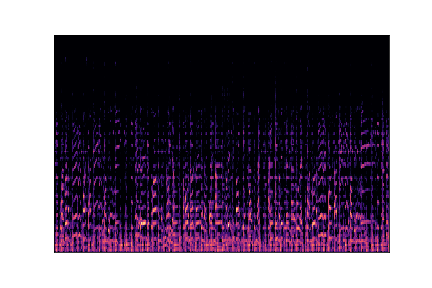

In [9]:
# Single Image Test
test_raw = fs.get_last_version("Data/images_original/blues/blues00000.png")
test_bytes = test_raw.read()
rgba_test = Image.open(io.BytesIO(test_bytes))
# RGBA Image (default)
rgba_test

In [10]:
# Converting RGBA TO RGB
rgb_test = rgba_test.convert("RGB")

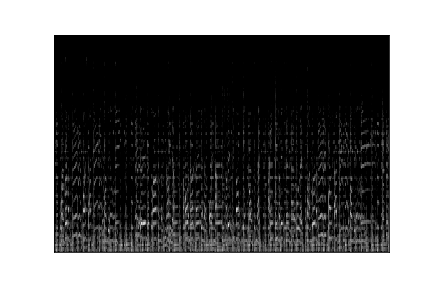

In [11]:
# Converting RGB to Grayscale
gray_test = ImageOps.grayscale(rgb_test)
gray_test

In [12]:
# Replicate single image loading/conversion to grayscale for all images
images = []
genres = []

for folder in images_folder:
    # Get files in each image-genre folder
    byte_files = subprocess.check_output(["ls", cwd + images_path + folder])
    files = byte_files.decode("utf-8").split("\n")
    files.pop(-1)
    
    for file in files:
        # Load image using its relative path as its GridFS identifier
        file_path = images_path + folder + "/" + file
        image_raw = fs.get_last_version(file_path)
        image_bytes = image_raw.read()
        rgba_image = Image.open(io.BytesIO(image_bytes))
        rgb_image = rgba_image.convert("RGB")
        gray_image = ImageOps.grayscale(rgb_image)
        image_data = np.asarray(gray_image)
        images.append(image_data)
        genres.append(folder)

In [13]:
# Convert image/genre lists to numpy arrays
images = np.asarray(images)
genres = np.asarray(genres)

# Supervised Machine Learning Models to Predict `label` from feature data

## `RandomForestClassifier`
### `features_3_sec.csv`

In [14]:
# Separate Features (X) from the Target (y)
y = features_3_df["label"]
X = features_3_df.drop(columns="label", axis=1)

In [15]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [16]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [17]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [21]:
# Instantiate the model
rf_3_model = RandomForestClassifier(n_estimators=1400, min_samples_split=2, min_samples_leaf=1,
                                    max_features="auto", max_depth=40, bootstrap=False)  # CHANGEABLE for bar plot comparisons

# Fit the model
rf_3_model = rf_3_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_3_pred = rf_3_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_3_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,8,8
1,8,8
2,9,9
3,0,0
4,6,9
...,...,...
2493,1,1
2494,3,3
2495,0,2
2496,0,0


In [22]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_3_pred)

Text(26.499999999999996, 0.5, 'True')

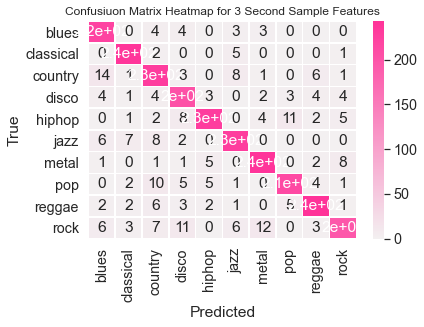

In [23]:
sortedlabels = genre_nums.keys()
cm_df = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)

sns.set(font_scale=1.3)
sns.heatmap(cm_df, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6), n_colors=10000), annot=True)
sns.set(rc={"figure.figsize": (15.0, 13.0)})

plt.title("Confusiuon Matrix Heatmap for 3 Second Sample Features")
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_3_pred)
acc_score

In [ ]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_3_pred))

In [ ]:
classification_report_3_second = sklearn.metrics.classification_report(y_test, rf_3_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_3_second[str(i)]
total_accuracy = classification_report_3_second["accuracy"]
common_metrics = {"macro avg": classification_report_3_second["macro avg"],
                  "weighted avg": classification_report_3_second["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [ ]:
print("Total Accuracy:", total_accuracy)

In [ ]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_Metrics_3_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [ ]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_3_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [ ]:
# Most important features
# List in descending order by feature importance
importances = rf_3_model.feature_importances_
sorted(zip(importances, X), reverse=True)[:5]

### `features_30_sec.csv`

In [24]:
# Separate Features (X) from the Target (y)
y = features_30_df["label"]
X = features_30_df.drop(columns="label", axis=1)

In [25]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
1,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


In [26]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [27]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [28]:
# Instantiate the model
rf_30_model = RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=1,
                                     max_features="sqrt", max_depth=90, bootstrap=False) # CHANGEABLE for bar plot comparisons

# Fit the model
rf_30_model = rf_30_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_30_pred = rf_30_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_30_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,9,9
1,8,8
2,2,2
3,5,5
4,6,6
...,...,...
245,4,4
246,9,3
247,9,0
248,4,4


In [29]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_30_pred)

Text(107.5, 0.5, 'True')

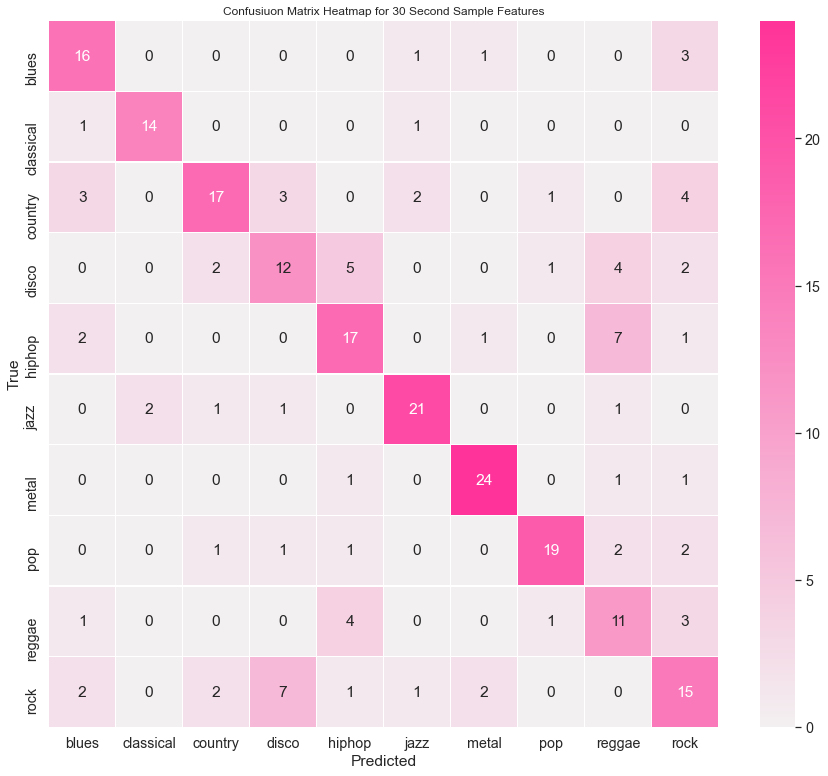

In [30]:
sortedlabels = genre_nums.keys()
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.3)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6), n_colors=10000), annot=True)
sns.set(rc={"figure.figsize": (15.0, 13.0)})

plt.title("Confusiuon Matrix Heatmap for 30 Second Sample Features")
plt.xlabel("Predicted")
plt.ylabel("True")

In [31]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_30_pred)
acc_score

0.664

In [32]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_30_pred))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70        21
           1       0.88      0.88      0.88        16
           2       0.74      0.57      0.64        30
           3       0.50      0.46      0.48        26
           4       0.59      0.61      0.60        28
           5       0.81      0.81      0.81        26
           6       0.86      0.89      0.87        27
           7       0.86      0.73      0.79        26
           8       0.42      0.55      0.48        20
           9       0.48      0.50      0.49        30

    accuracy                           0.66       250
   macro avg       0.68      0.67      0.67       250
weighted avg       0.67      0.66      0.67       250



In [33]:
classification_report_30_second = sklearn.metrics.classification_report(y_test, rf_30_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_30_second[str(i)]
total_accuracy = classification_report_30_second["accuracy"]
common_metrics = {"macro avg": classification_report_30_second["macro avg"],
                  "weighted avg": classification_report_30_second["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [36]:
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.664


In [ ]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [ ]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [37]:
# Most important features
# List in descending order by feature importance
importances = rf_30_model.feature_importances_
sorted(zip(importances, X), reverse=True)[:5]

[(0.05282218290874538, 'perceptr_var'),
 (0.04914247237618035, 'chroma_stft_mean'),
 (0.03501455897589473, 'rms_mean'),
 (0.03360988935774382, 'rms_var'),
 (0.03207768667128452, 'chroma_stft_var')]

# Unsupervised Machine Learning Models to Predict `label` from feature data
## `KMeans` Cluster
### `features_3_sec.csv`

In [ ]:
# Unsupervised Machine Learning Models to Predict `label` from feature data
# K-Means Cluster Model with 10 clusters (10 known genres)
# First shuffle the rows in DataFrame so the classes are not pre-grouped
# Needed here since not using sklearn.model_selection.train_test_split (no testing data)
features_3_df_shuffled = features_3_df.sample(frac=1)
features_3_df_shuffled

In [ ]:
# Separate Features (X) from the Target (y)
y = features_3_df_shuffled["label"]
X = features_3_df_shuffled.drop(columns="label", axis=1)

In [ ]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

In [ ]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

In [ ]:
# Standardize features with StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA model with 3 principal components to visualize clusters vs. components
pca = PCA(n_components=3)

# Fit pca model to the 30 sec music feature data, X
X_pca = pca.fit_transform(X_scaled)

# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=X_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_pca.head()

In [ ]:
# Fetch the explained variance
pca.explained_variance_ratio_  # 1st component contains 20% of variance, 2nd contains 14%, 3rd contains 10%

In [ ]:
# Initialize the K-means model
km_3_model = KMeans(n_clusters=10, random_state=0)

# Fit the model
km_3_model.fit(df_pca)

# Predict clusters
predictions = km_3_model.predict(df_pca)

# Add the predicted and actual class columns
pred_classes = []
act_classes = []

for label in km_3_model.labels_:
    pred_classes.append(list(genre_nums.keys())[list(genre_nums.values()).index(label)])
for label in np.asarray(y):
    act_classes.append(list(genre_nums.keys())[list(genre_nums.values()).index(label)])

df_pca["predicted class"] = pred_classes
df_pca["actual class"] = act_classes
df_pca

In [ ]:
# Plotting clusters with three features
fig = px.scatter_3d(df_pca, x="principal component 1", y="principal component 2", z="principal component 3",
                    color="predicted class", symbol="predicted class", width=800, title="Predicted Genre Clusters",
                    hover_data=["actual class"])
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [ ]:
# Labels not insightful, no reason for program to label all "blues" as 0
# Check number of each prediction:
df_pca["predicted class"].value_counts(sort=False)

In [ ]:
# Compare to actual class breakdown
df_pca["actual class"].value_counts(sort=False)

In [ ]:
# Check number of actual class labels for a single predicted label
# Ideally we would find many of one actual class label and few of others for each predicted label, and a unique most 
# popular actual label for each predicted label
act_pred_results = np.zeros((10, 10), dtype=int)
col_names = []
for i in range(10):
    for j in range(10):
        try:
            act_pred_results[i, j] = df_pca[df_pca["predicted class"] == i]["actual class"].value_counts(sort=False)[j]
        except KeyError:
            act_pred_results[i, j] = 0
    col_names.append("Number of Actual %s" % i)

act_pred_results_df = pd.DataFrame(data=act_pred_results,
                                   columns=col_names)

In [ ]:
act_pred_results_df.columns = list(genre_nums.keys())
act_pred_results_df.index = list(genre_nums.keys())
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df = act_pred_results_df[["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"]]
act_pred_results_df = act_pred_results_df.reindex(["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"])
act_pred_results_df

In [ ]:
result = act_pred_results_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/act_pred_3_sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

### `features_30_sec.csv`

In [ ]:
# Unsupervised Machine Learning Models to Predict `label` from feature data
# K-Means Cluster Model with 10 clusters (10 known genres)
# First shuffle the rows in DataFrame so the classes are not pre-grouped
# Needed here since not using sklearn.model_selection.train_test_split (no testing data)
features_30_df_shuffled = features_30_df.sample(frac=1)
features_30_df_shuffled

In [ ]:
# Separate Features (X) from the Target (y)
y = features_30_df_shuffled["label"]
X = features_30_df_shuffled.drop(columns="label", axis=1)

In [ ]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

In [ ]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

In [ ]:
# Standardize features with StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA model with 3 principal components to visualize clusters vs. components
pca = PCA(n_components=3)

# Fit pca model to the 30 sec music feature data, X
X_pca = pca.fit_transform(X_scaled)

# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=X_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_pca.head()

In [ ]:
# Fetch the explained variance
pca.explained_variance_ratio_  # 1st component contains 24% of variance, 2nd contains 17%, 3rd contains 11%

In [ ]:
# Initialize the K-means model
km_30_model = KMeans(n_clusters=10, random_state=0)

# Fit the model
km_30_model.fit(df_pca)

# Predict clusters
predictions = km_30_model.predict(df_pca)

# Add the predicted and actual class columns
pred_classes = []
act_classes = []

for label in km_30_model.labels_:
    pred_classes.append(list(genre_nums.keys())[list(genre_nums.values()).index(label)])
for label in np.asarray(y):
    act_classes.append(list(genre_nums.keys())[list(genre_nums.values()).index(label)])

# Add the preicted class columns
df_pca["predicted class"] = pred_classes
df_pca["actual class"] = act_classes
df_pca

In [ ]:
# Plotting clusters with three features
fig = px.scatter_3d(df_pca, x="principal component 1", y="principal component 2", z="principal component 3",
                    color="predicted class", symbol="predicted class", width=800, title="Predicted Genre Clusters",
                    hover_data=["actual class"])
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [ ]:
# Labels not insightful, no reason for program to label all "blues" as 0
# Check number of each prediction:
df_pca["predicted class"].value_counts(sort=False)

In [ ]:
# Compare to actual class breakdown
df_pca["actual class"].value_counts(sort=False)

In [20]:
# Check number of actual class labels for a single predicted label
# Ideally we would find many of one actual class label and few of others for each predicted label, and a unique most 
# popular actual label for each predicted label
act_pred_results = np.zeros((10, 10), dtype=int)
col_names = []
for i in range(10):
    for j in range(10):
        try:
            act_pred_results[i, j] = df_pca[df_pca["predicted class"] == i]["actual class"].value_counts(sort=False)[j]
        except KeyError:
            act_pred_results[i, j] = 0
    col_names.append("Number of Actual %s" % i)

act_pred_results_df = pd.DataFrame(data=act_pred_results,
                                   columns=col_names)

NameError: name 'df_pca' is not defined

In [ ]:
act_pred_results_df.columns = list(genre_nums.keys())
act_pred_results_df.index = list(genre_nums.keys())
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df = act_pred_results_df[["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"]]
act_pred_results_df = act_pred_results_df.reindex(["jazz", "metal", "disco", "pop", "reggae", "classical", "rock", "blues", "hiphop", "country"])
act_pred_results_df

In [ ]:
result = act_pred_results_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/act_pred_30_sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

# Neural Network to Predict `label` from Images

In [ ]:
# Copy images and labels into new NumPy arrays
X = np.copy(images)
y = np.copy(genres)

In [ ]:
# Convert categorical labels to integers 0 - 9
y = np.vectorize(genre_nums.get)(y)

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# Normalize pixel data:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
# Define Neural Net
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[288, 432]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")])

In [ ]:
# Print model summary
model.summary()

In [ ]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=200)

In [ ]:
# Plot training results
history_df = pd.DataFrame(history.history,
                          index=range(1, len(history.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="red", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Results")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="blue", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [ ]:
# Evaluate model
model.evaluate(X_test, y_test)  # Likely overfitting: 0.6 training accuracy -> 0.34 testing accuracy

In [ ]:
nn_pred_probs = model.predict(X_test)
nn_pred = np.argmax(nn_pred_probs, axis=1)
results = pd.DataFrame({
    "Prediction": nn_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

In [ ]:
classification_report_nn = sklearn.metrics.classification_report(y_test, nn_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_nn[str(i)]
total_accuracy = classification_report_nn["accuracy"]
common_metrics = {"macro avg": classification_report_nn["macro avg"],
                  "weighted avg": classification_report_nn["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [ ]:
print("Total Accuracy:", total_accuracy)

In [ ]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_metrics_nn.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [ ]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()